In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
#load data
mnist_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# make validation set

train_length = len(mnist_train)
train_size = int(0.85 * train_length)
val_size = train_length - train_size

mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [train_size, val_size])

# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []
train_acc_list = []
val_acc_list = []

0.2%

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



3.5%

100.6%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



19.9%

119.3%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw




C:\Users\lewiis\anaconda3\envs\deep_learning\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


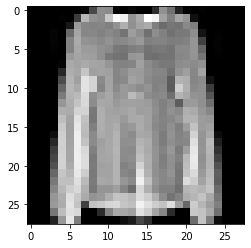

In [4]:
# visualise sample of data to know what we are dealing with
plt.figure(1)
img, label = mnist_train[5]
plt.imshow(img.squeeze(), cmap='gray')

In [5]:
img.size()

torch.Size([1, 28, 28])

In [6]:
# make network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 16 from batchnorm, 14 from pooling
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128,10)
        # self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64 * 7 * 7)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        # out = self.act2(out)
        return out


In [7]:
# train and test loop
def train_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            # move tensors to gpu
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())
            train_correct = correct
            train_total = total

        epoch_list.append(epoch)
        train_loss_list.append(loss_train / len(train_loader))

        # get loss of validation data
        with torch.no_grad():
            loss_val = 0.0
            correct = 0
            total = 0
            for imgs, labels in val_loader:
                # move tensors to gpu if available
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)

                loss_v = loss_fn(outputs, labels)

                loss_val += loss_v.item()

                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())
            val_correct = correct
            val_total = total


        val_loss_list.append(loss_val / len(val_loader))

        train_acc_list.append(train_correct/train_total)
        val_acc_list.append(val_correct/val_total)

        # set when to print info about training progress
        if epoch == 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}, Train Acc {}, Val Acc {}'.format(epoch, loss_train / len(train_loader), loss_val / len(val_loader), train_correct/train_total, val_correct/val_total),
                  )

def test_loop(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            # move to gpu
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())


    print("Accuracy test: {:.2f} %".format(100 *  (correct / total)))

In [8]:
# set model and params
n_epochs = 10
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test,  batch_size=64, shuffle=False)
# epoch_num_of_no_improve = 5

train_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)

test_loop(model, test_loader)

C:\Users\lewiis\anaconda3\envs\deep_learning\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Training loss 0.5449360631490442, Validation loss 0.3481341565543033, Train Acc 0.8294509803921568, Val Acc 0.925
Epoch 2, Training loss 0.29179016247373, Validation loss 0.31039894757964087, Train Acc 0.8944117647058824, Val Acc 0.9
Epoch 3, Training loss 0.2519544725080805, Validation loss 0.28648693352303606, Train Acc 0.9087254901960784, Val Acc 0.925
Epoch 4, Training loss 0.22438611909092743, Validation loss 0.3028471253231062, Train Acc 0.9188039215686274, Val Acc 0.9
Epoch 5, Training loss 0.20900747635129516, Validation loss 0.34248861924130863, Train Acc 0.9234509803921569, Val Acc 0.925
Epoch 6, Training loss 0.192275751365753, Validation loss 0.3376616381161602, Train Acc 0.9304509803921569, Val Acc 0.9
Epoch 7, Training loss 0.1795465759372098, Validation loss 0.33208184060475504, Train Acc 0.9349411764705883, Val Acc 0.9
Epoch 8, Training loss 0.17051799922779556, Validation loss 0.3222051965640792, Train Acc 0.9384117647058824, Val Acc 0.95
Epoch 9, Training los

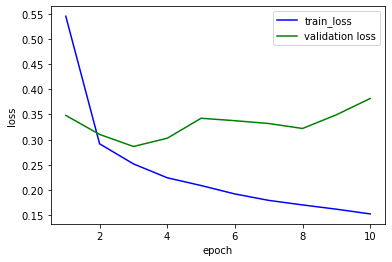

In [9]:
plt.figure(2)
plt.plot(epoch_list, train_loss_list, color='blue', label='train_loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

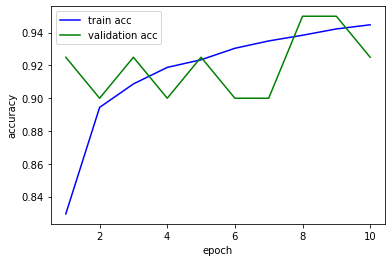

In [10]:
plt.figure(3)
plt.plot(epoch_list, train_acc_list, color='blue', label='train acc')
plt.plot(epoch_list, val_acc_list, color='green', label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Text(230.20000000000005, 0.5, 'predicted label')

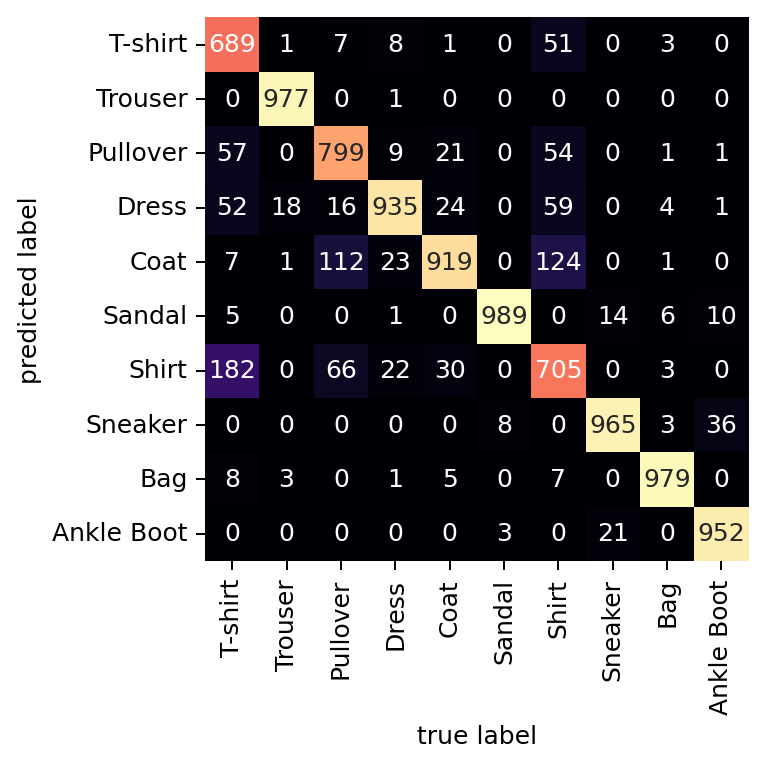

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_fit = np.array([])
y_test = np.array([])

for imgs, labels in test_loader:
    model = model.to('cpu')

    outputs = model(imgs)

    _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
    predicted = predicted.detach().numpy()
    labels = labels.detach().numpy()
    y_fit = np.concatenate((y_fit, predicted), axis=None)
    y_test = np.concatenate((y_test, labels), axis=None)
    # y_fit.append(predicted)
    # y_test.append(labels)

labels_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

plt.figure(6, dpi=180)
conf_matrix = confusion_matrix(y_test, y_fit)
conf_matrix = pd.DataFrame(conf_matrix)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names, cmap='magma')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [12]:
import torch.onnx as onnx
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights_fashion_mnist.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\lewiis/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%
